# Analysing Smartphone Prices

In [ ]:
import requests
from urllib import parse
import re

import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

## 1. Loading Devices Names

In [2]:
RELATIVE_PATH_TO_DATA_FOLDER = './data/'
filename = 'devices_using_ribonapp_data'
filename_with_path = RELATIVE_PATH_TO_DATA_FOLDER + filename + '.csv'
devices_df = pd.read_csv(filename_with_path, skiprows=0, names=['model_name', 'old_price_range'])
devices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1130 entries, 0 to 1129
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   model_name       1130 non-null   object
 1   old_price_range  1130 non-null   object
dtypes: object(2)
memory usage: 17.8+ KB


### 1.1 Cleaning Duplicates and Missing Values

In [3]:
devices_df.drop_duplicates(['model_name'], inplace=True)
devices_df.dropna(axis=0, inplace=True)
devices_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1130 entries, 0 to 1129
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   model_name       1130 non-null   object
 1   old_price_range  1130 non-null   object
dtypes: object(2)
memory usage: 26.5+ KB


## 2. Searching for Prices

In [ ]:
url_base = "https://celulares.mercadolivre.com.br/"
item_list = devices_df['model_name'].to_list()

url_list = [url_base + parse.quote(item_name) for item_name in item_list]
item_list_tuple = []

for url, item_original_name in tdqm(zip(url_list, item_list)):
    r = requests.get(url)
    text_content = str(r.text)
    item_name = re.search(r'class="main-title">([\s\S]+?)<\/span>', text_content)
    item_price = re.search(r'price__fraction">(\S+)<\/span>', text_content)
    if item_name:
        item_name = item_name.groups()[0]
    if item_price:
        item_price = item_price.groups()[0]
    item_list_tuple.append((item_original_name, item_name, item_price))


extracted_data_df = pd.DataFrame(data=item_list_tuple, columns=['item_original_name','item_extracted_name', 'item_price'])
print(extracted_data_df.info())

### 2.1 Treating Data

In [ ]:
%time
extracted_data_df.dropna(axis=0, inplace=True)
item_raw_prices_list = extracted_data_df['item_price'].to_list()
item_treated_prices_list = []
for item_raw_price in item_raw_prices_list:
    item_price = None
    if '.' in item_raw_price:
        thousands_digits, hundreds_digits = item_raw_price.split('.')
        item_price = int(thousands_digits)*1000 + int(hundreds_digits)
    else:
        item_price = int(item_raw_price)
    item_treated_prices_list.append(item_price)
extracted_data_df['item_price'] = item_treated_prices_list
extracted_data_df

### 2.1 Storing Found Prices

In [5]:
extracted_filename = 'extracted_device_data'
extracted_filename_with_path = RELATIVE_PATH_TO_DATA_FOLDER + extracted_filename + '.csv'

In [ ]:
extracted_data_df.to_csv(extracted_filename_with_path, index=False)

## 3. Analysing Prices

In [6]:
device_extracted_data_df = pd.read_csv(extracted_filename_with_path, header=0)
device_extracted_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903 entries, 0 to 902
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   item_original_name   903 non-null    object
 1   item_extracted_name  903 non-null    object
 2   item_price           903 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.3+ KB


### 3.1 Prices Distribution

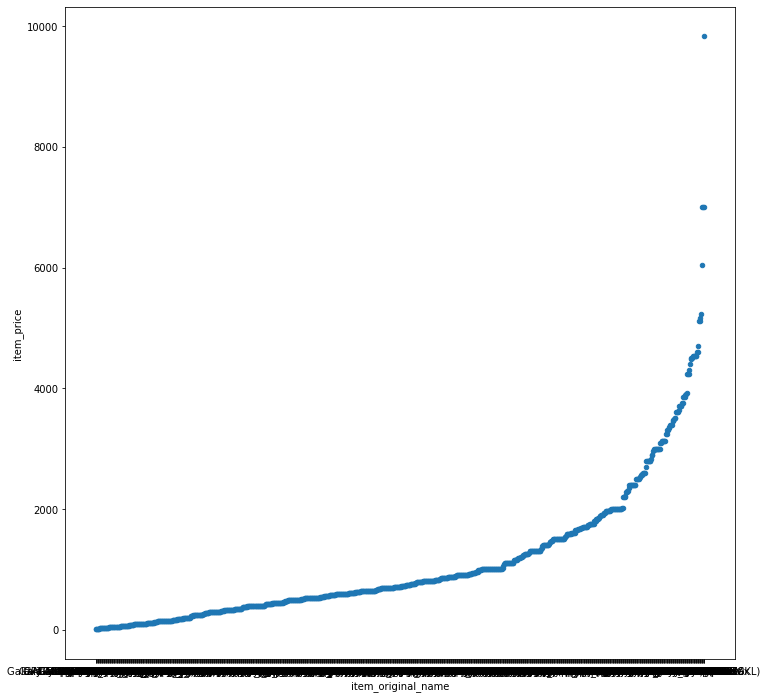

In [7]:
device_extracted_data_df.sort_values(by='item_price', inplace=True)
device_extracted_data_df.plot.scatter(x=0, y='item_price', figsize=(12, 12))

### 3.2 Prices Binning

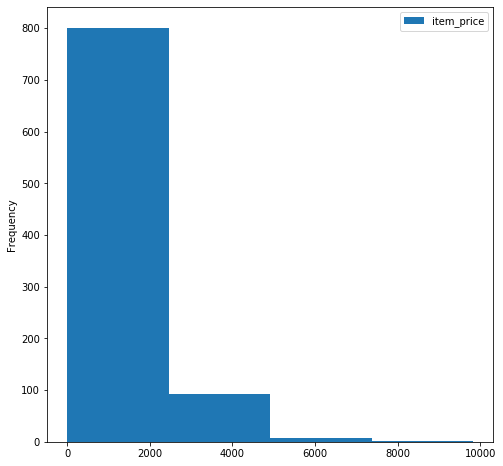

In [8]:
device_extracted_data_df.describe()
device_extracted_data_df.plot.hist(by=['item_price'], bins=4, figsize=(8, 8))


#### Using Quantiles

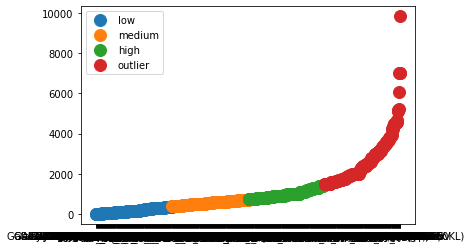

In [9]:
price_range_labels = ['low', 'medium', 'high', 'outlier']
device_extracted_data_df['price_range_q'] = pd.qcut(device_extracted_data_df['item_price'], q=4, labels=price_range_labels)
groups = device_extracted_data_df.groupby('price_range_q')
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['item_original_name'], group['item_price'], marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

#### Using Binning

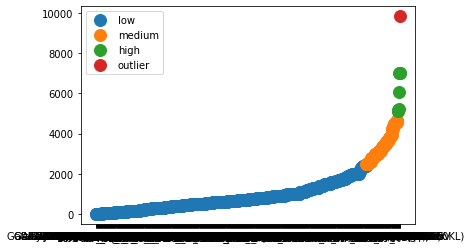

In [10]:
price_range_labels = ['low', 'medium', 'high', 'outlier']
device_extracted_data_df['price_range_bin'] = pd.cut(device_extracted_data_df['item_price'], bins=4, labels=price_range_labels)
groups = device_extracted_data_df.groupby('price_range_bin')
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['item_original_name'], group['item_price'], marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

#### Comparing with old price ranges

In [11]:
device_extracted_data_df = device_extracted_data_df.merge(right=devices_df, left_on='item_original_name', right_on='model_name', how='inner').drop(columns='model_name')
device_extracted_data_df

,item_original_name,item_extracted_name,item_price,price_range_q,price_range_bin,old_price_range
0,Breeze 7Y2241,Conector Micro Usb Tablet Aoc Breeze Aoc 7 7y...,6,low,low,Low
1,Galaxy Trend Lite GT-S7392L DUOS,Celular Samsung Galaxy Trend Lite Gt-s7392l P...,15,low,low,Mid_Range
2,E470f,Smartphone Lg E470f Branco Apenas Partes Pçs....,18,low,low,Low
3,Motion,Smartphone Cce Motion Plus Sm70 - Defeito,19,low,low,Low
4,Galaxy Pocket 2,Smartphone Samsung Galaxy Pocket 2 Duos Sm-g1...,19,low,low,Mid_Range
...,...,...,...,...,...,...
898,One Pro,OnePlus 7T Pro McLaren Edition Dual SIM 256 G...,6049,outlier,high,Low
899,iPhone 11 Pro,Apple iPhone 11 Pro Max Dual SIM 64 GB Cinza-...,7000,outlier,high,High
900,iPhone 11 Pro Max,Apple iPhone 11 Pro Max Dual SIM 64 GB Cinza-...,7000,outlier,high,High
901,Max 4 Pro,Apple iPhone 11 Pro Max Dual SIM 64 GB Cinza-...,7000,outlier,high,Low


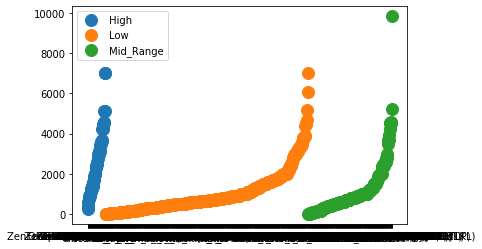

In [12]:
groups = device_extracted_data_df.groupby('old_price_range')
# Plot
fig, ax = plt.subplots()
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.plot(group['item_original_name'], group['item_price'], marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()